<a href="https://colab.research.google.com/github/markustoivonen/AIHealthTech2020/blob/master/exercises/ex4_4_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [90]:
import tensorflow as tf
from tensorflow.keras.layers import Dense, Flatten, Conv2D
from tensorflow.keras import Model
import matplotlib.pyplot as plt
from tensorflow.math import confusion_matrix
import numpy as np
from sklearn.metrics import roc_curve, precision_recall_curve

In [91]:
fashion_mnist = tf.keras.datasets.fashion_mnist

(x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()
x_train, x_test = x_train / 255.0, x_test / 255.0

train_idx = np.argwhere((y_train == 0) | (y_train == 1)).flatten()
test_idx = np.argwhere((y_test == 0) | (y_test == 1)).flatten()


In [92]:
x_train = x_train[train_idx, :, :]
x_test = x_test[test_idx, :, :]

y_train = y_train[train_idx]
y_test = y_test[test_idx]

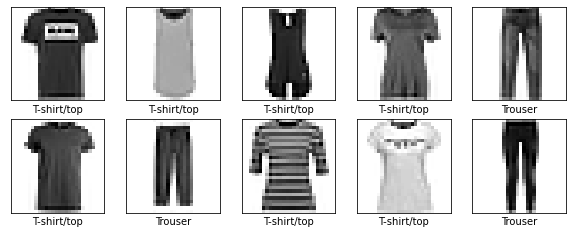

In [93]:
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat','Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']
plt.figure(figsize=(10,10))
for i in range(10):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(x_train[i], cmap=plt.cm.binary)
    plt.xlabel(class_names[y_train[i]])
plt.show()

In [94]:
# Add a channels dimension
x_train = x_train[..., tf.newaxis].astype("float32")
x_test = x_test[..., tf.newaxis].astype("float32")


In [95]:
train_ds = tf.data.Dataset.from_tensor_slices(
    (x_train, y_train)).shuffle(10000).batch(32)

test_ds = tf.data.Dataset.from_tensor_slices((x_test, y_test)).batch(32)

In [96]:
class binaryModel(Model):
  def __init__(self):
    super(binaryModel, self).__init__()
    self.conv1 = Conv2D(32, 3, activation='relu')
    self.flatten = Flatten()
    self.d1 = Dense(128, activation='relu')
    self.d2 = Dense(2)

  def call(self, x):
    x = self.conv1(x)
    x = self.flatten(x)
    x = self.d1(x)
    return self.d2(x)

# Create an instance of the model
model = binaryModel()

loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)

optimizer = tf.keras.optimizers.Adam()

train_loss = tf.keras.metrics.Mean(name='train_loss')
train_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name='train_accuracy')

test_loss = tf.keras.metrics.Mean(name='test_loss')
test_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name='test_accuracy')


@tf.function
def train_step(images, labels):
  with tf.GradientTape() as tape:
    # training=True is only needed if there are layers with different
    # behavior during training versus inference (e.g. Dropout).
    predictions = model(images, training=True)
    loss = loss_object(labels, predictions)
  gradients = tape.gradient(loss, model.trainable_variables)
  optimizer.apply_gradients(zip(gradients, model.trainable_variables))

  train_loss(loss)
  train_accuracy(labels, predictions)

@tf.function
def test_step(images, labels):
  # training=False is only needed if there are layers with different
  # behavior during training versus inference (e.g. Dropout).
  predictions = model(images, training=False)
  t_loss = loss_object(labels, predictions)

  test_loss(t_loss)
  test_accuracy(labels, predictions)


In [98]:
def plot_statistics(labels, predictions):

  fpr, tpr, _ = roc_curve(labels, predictions)
  pr, rc, _ = precision_recall_curve(labels, predictions)

  print("Confusion matrix:\n", confusion_matrix(labels, predictions))
  plt.figure(1)
  plt.plot([0, 1], [0, 1], 'k--')
  plt.plot(fpr, tpr)
  plt.xlabel('False positive rate')
  plt.ylabel('True positive rate')
  plt.title('ROC curve')
  plt.show()

  plt.figure(1)
  plt.plot(rc, pr)
  plt.xlabel('Recall')
  plt.ylabel('Precision')
  plt.title('PR curve')
  plt.show()

Confusion matrix:
 tf.Tensor(
[[ 976   24]
 [1000    0]], shape=(2, 2), dtype=int32)


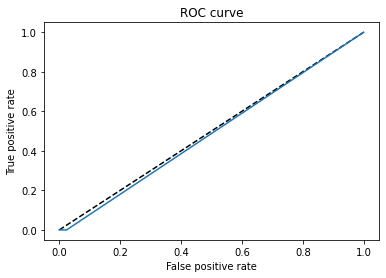

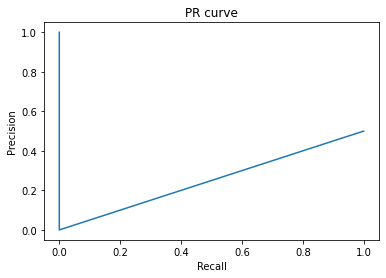

In [99]:
predictions = tf.argmax(model(x_test),1)
labels = y_test
plot_statistics(labels, predictions)

In [100]:
EPOCHS = 5

for epoch in range(EPOCHS):
  # Reset the metrics at the start of the next epoch
  train_loss.reset_states()
  train_accuracy.reset_states()
  test_loss.reset_states()
  test_accuracy.reset_states()

  for images, labels in train_ds:
    train_step(images, labels)

  for test_images, test_labels in test_ds:
    test_step(test_images, test_labels)

  template = 'Epoch {}, Loss: {}, Accuracy: {}, Test Loss: {}, Test Accuracy: {}'
  print(template.format(epoch + 1,
                        train_loss.result(),
                        train_accuracy.result() * 100,
                        test_loss.result(),
                        test_accuracy.result() * 100))


Epoch 1, Loss: 0.039307404309511185, Accuracy: 98.55833435058594, Test Loss: 0.019746843725442886, Test Accuracy: 99.19999694824219
Epoch 2, Loss: 0.01420464925467968, Accuracy: 99.63333892822266, Test Loss: 0.0257114227861166, Test Accuracy: 99.19999694824219
Epoch 3, Loss: 0.008493106812238693, Accuracy: 99.73333740234375, Test Loss: 0.023169605061411858, Test Accuracy: 99.19999694824219
Epoch 4, Loss: 0.0036845910362899303, Accuracy: 99.92500305175781, Test Loss: 0.020555971190333366, Test Accuracy: 99.4000015258789
Epoch 5, Loss: 0.0014191365335136652, Accuracy: 99.9749984741211, Test Loss: 0.018051661550998688, Test Accuracy: 99.5


Confusion matrix:
 tf.Tensor(
[[997   3]
 [  7 993]], shape=(2, 2), dtype=int32)


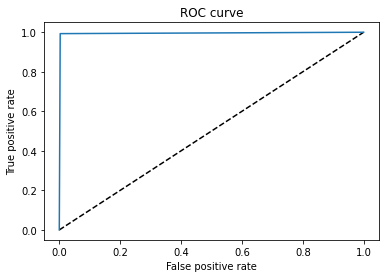

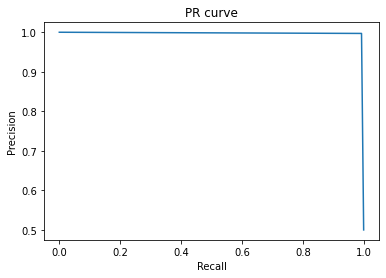

In [101]:
predictions = tf.argmax(model(x_test),1)
labels = y_test
plot_statistics(labels, predictions)